<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Figure-19.1" data-toc-modified-id="Figure-19.1-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Figure 19.1</a></span></li><li><span><a href="#Figure-19.2" data-toc-modified-id="Figure-19.2-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Figure 19.2</a></span></li><li><span><a href="#Figure-19.3" data-toc-modified-id="Figure-19.3-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Figure 19.3</a></span></li><li><span><a href="#Figure-19.4" data-toc-modified-id="Figure-19.4-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Figure 19.4</a></span></li><li><span><a href="#Figure-19.5" data-toc-modified-id="Figure-19.5-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Figure 19.5</a></span></li><li><span><a href="#Figure-19.6" data-toc-modified-id="Figure-19.6-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Figure 19.6</a></span></li><li><span><a href="#Figure-34.8" data-toc-modified-id="Figure-34.8-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Figure 34.8</a></span></li><li><span><a href="#Figure-19.7" data-toc-modified-id="Figure-19.7-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Figure 19.7</a></span></li><li><span><a href="#Figure-19.8" data-toc-modified-id="Figure-19.8-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Figure 19.8</a></span></li><li><span><a href="#Figure-19.9" data-toc-modified-id="Figure-19.9-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Figure 19.9</a></span></li><li><span><a href="#Figure-19.10" data-toc-modified-id="Figure-19.10-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Figure 19.10</a></span></li><li><span><a href="#Figure-19.11" data-toc-modified-id="Figure-19.11-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Figure 19.11</a></span></li><li><span><a href="#Figure-19.12" data-toc-modified-id="Figure-19.12-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Figure 19.12</a></span></li></ul></div>

In [1]:
## Analyzing Neural Time Series Data
# Python code for Chapter 19
# Yujin Goto (MATLAB original code: Mike X Cohen)
# 
# This code accompanies the book, titled "Analyzing Neural Time Series Data" 
# (MIT Press). Using the code without following the book may lead to confusion, 
# incorrect data analyses, and misinterpretations of results. 
# Mike X Cohen and Yujin Goto assumes no responsibility for inappropriate or incorrect use of this code. 

In [2]:
import numpy as np
from matplotlib import pyplot as plt

from scipy import signal as sig
from scipy.stats import zscore

import mne
from mne import events_from_annotations

In [3]:
# load EEG data (.vhdr converted ver. by Yujin)
mne.set_log_level('CRITICAL') # delete this line for your environment
raw = mne.io.read_raw_brainvision('./NeuralData/sampleEEGdata_convert.vhdr', eog=['HEOG', 'VEOG'], preload=True)
mne.set_log_level('INFO') # delete this line for your environment

# load electrodes location montage
montage = mne.channels.read_custom_montage('./NeuralData/sampleEEG_loc.loc')
raw.set_montage(montage)

# Getting event timings (for .mat file, you don't have to do this.) and epoching
events, event_dict = events_from_annotations(raw)

epochs = mne.Epochs(
    raw,
    events,
    event_id = {'New Segment/': 99999},
    tmin = 0,
    tmax = 2.496,
    baseline = None,
)

# Extract variables
data = epochs.get_data()*(10**6)                 # EEG data (array; trial, ch, time). MNE-pyton reads data in volts(V), not microvolts (μV).
pnts = data.shape[2]                             # Number of points in EEG data (scalar)
times = epochs.times-1                           # Time points of data (array)
tmin = epochs.tmin-1                             # The start timing of epoch (the start timing of the baseline is set to be 0 in default)
tmax = epochs.tmax-1                             # The end timing of epoch
srate = epochs.info['sfreq']                     # Sampling rate (scalar)
trials = len(epochs.events)                      # Trials (scalar)
nbchan = len(epochs.ch_names)                    # Number of channel (scalar)


chan_labels = epochs.info['ch_names']

# channel locations
chan_pos = []
for ch in epochs.info['chs']:
    x,y,z = ch['loc'][:3]
    chan_pos.append((x,y,z))
    
#chan2useidx = chan_labels.index('Pz')

Used Annotations descriptions: ['New Segment/', 'Stimulus/1', 'Stimulus/2', 'Stimulus/31', 'Stimulus/32', 'Stimulus/51', 'Stimulus/52']
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 99 events and 640 original time points ...
0 bad epochs dropped


## Figure 19.1

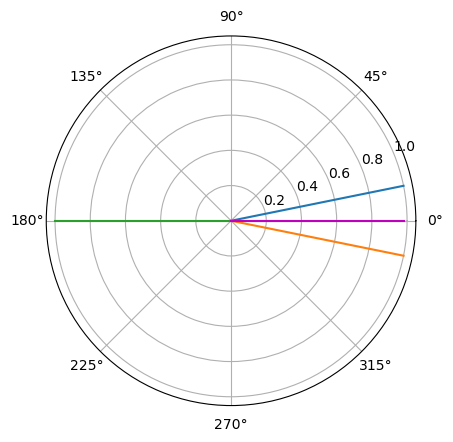

In [4]:
# define angles
a= np.array((.2, 2*np.pi-.2))

# plot unit vectors defined by those angles
plt.polar([[0,0], [*a]], [[0,0],[1,1]])

# plot a unit vector with the average angle
plt.polar([0, np.mean(a)], [0, 1])

# plot the average vector
_=plt.polar([0, np.angle(np.mean(np.exp(1j*a)))],[0, np.abs(np.mean(np.exp(1j*a)))], 'm')

## Figure 19.2

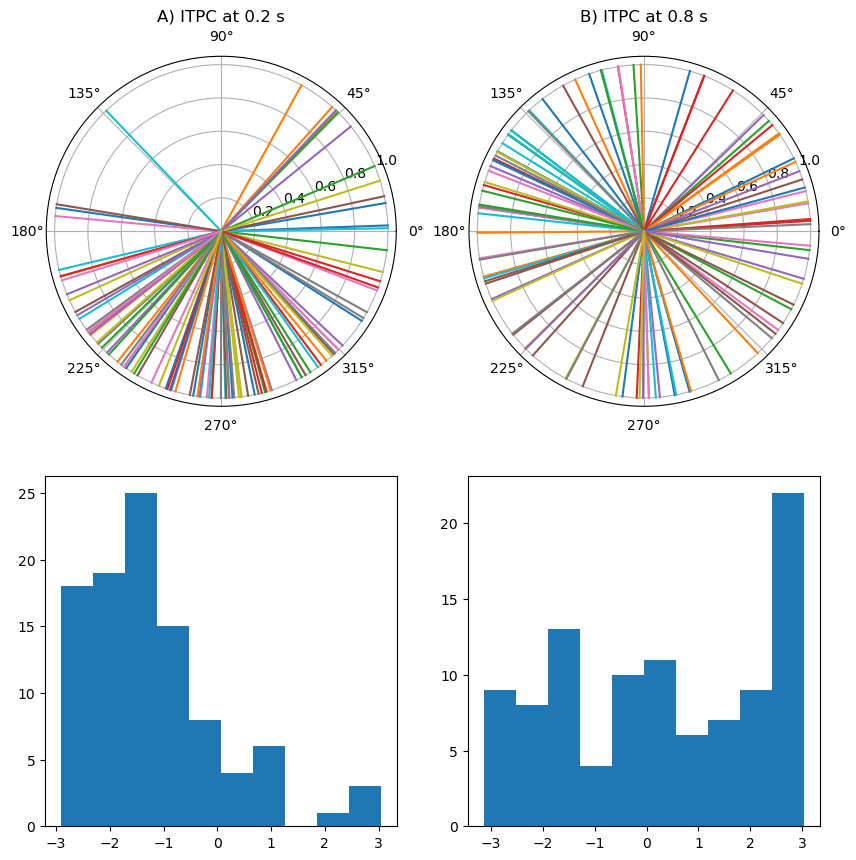

In [5]:
chan2plot= chan_labels.index('Pz')
centerfreq = 12  # in hz
times2plot = (.2, .8)  # in msec from stim onset

n_wavelet = pnts
n_data = pnts * trials
n_convolution = n_wavelet + n_data
n_conv_pow2 = int(2**np.ceil(np.log2(n_convolution)))

# create wavelet. Note that the time vector to create the wavelet uses the
# same number of points as there are in the EEG data. If the EEG data has
# an even number of points (which is the case here--640), the wavelet will
# not have an exact center point. Though not technically incorrect, using
# a wavelet with an even number of points should be avoided when possible.

time = np.arange(-1*pnts/srate/2,pnts/srate/2, 1/srate)
wavelet = np.exp(2 * 1j * np.pi * centerfreq * time) * np.exp(-time ** 2/ (2*((4/(2*np.pi*centerfreq))**2))) /centerfreq

# get FFT of data
eegfft = np.fft.fft(data[:,chan2plot,:].flatten(), n=n_conv_pow2)

# convolution
eegconv = np.fft.ifft(np.fft.fft(wavelet, n_conv_pow2) * eegfft)
eegconv = eegconv[:n_convolution]

# Cut the edges off the result of convolution. Because the wavelet here was
# created with the same number of time points as the EEG data, EEG.pnts
# also corresponds to the number of time points in the wavelet.
eegconv = np.reshape(eegconv[pnts//2: -1*pnts//2], [pnts, trials], order='f')



plt.figure(figsize=(10,10))
plt.subplot(2,2,1, polar=True)
idx = np.argmin(np.abs(times - times2plot[0]))
plt.polar(np.array([np.zeros(trials),np.angle(eegconv[idx])]), np.array([np.zeros(trials), np.ones(trials)]));
plt.title(f'A) ITPC at {times2plot[0]} s')

plt.subplot(2,2,3)
plt.hist(np.angle(eegconv[idx]))

plt.subplot(2,2,2, polar=True)
idx = np.argmin(np.abs(times - times2plot[1]))
plt.polar(np.array([np.zeros(trials),np.angle(eegconv[idx])]), np.array([np.zeros(trials), np.ones(trials)]))
plt.title(f'B) ITPC at {times2plot[1]} s')

plt.subplot(2,2,4)
_=plt.hist(np.angle(eegconv[idx]))

## Figure 19.3

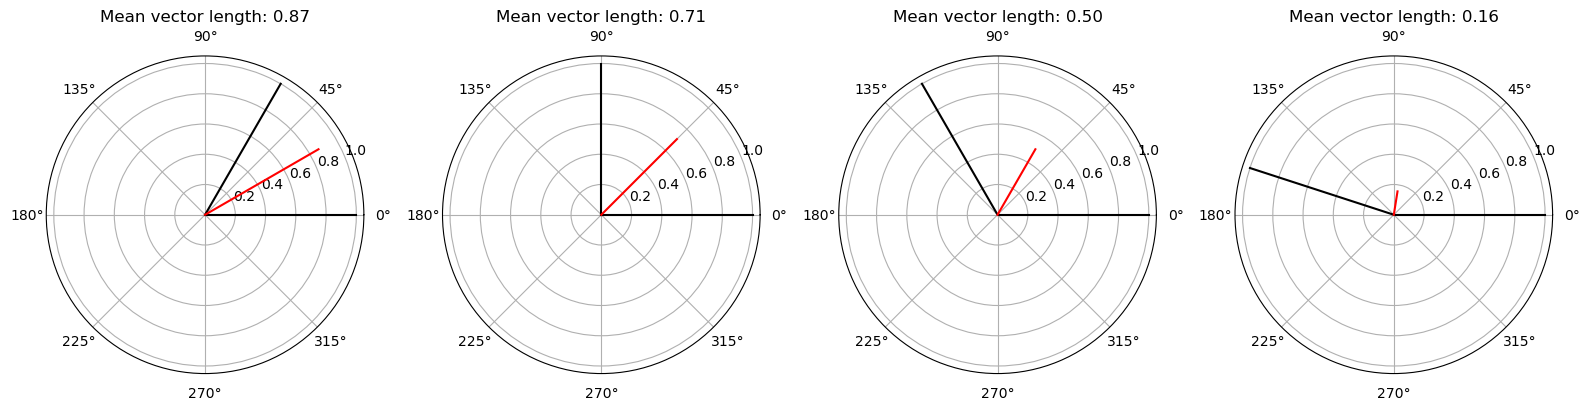

In [6]:
vectors = [(0, np.pi/3), (0, np.pi/2), (0, np.pi*2/3), (0, np.pi*.9)]
plt.figure(figsize=(16,4))

for i in range(len(vectors)):
    plt.subplot(1,4,i+1, polar=True)
    # plot individual unit vectors
    plt.plot([0,vectors[i][0]], [0,1], 'k')
    plt.plot([0,vectors[i][1]], [0,1], 'k')
    
    # plot mean vector (ignore the math for now, 
    # this will be discussed later in the chapter)
    mean_vec = np.mean(np.exp(1j * np.array(vectors[i])))
    plt.plot([0, np.angle(mean_vec)], [0, np.abs(mean_vec)], 'r')
    plt.title(f'Mean vector length: {np.abs(mean_vec):.2f}')

plt.tight_layout()

## Figure 19.4

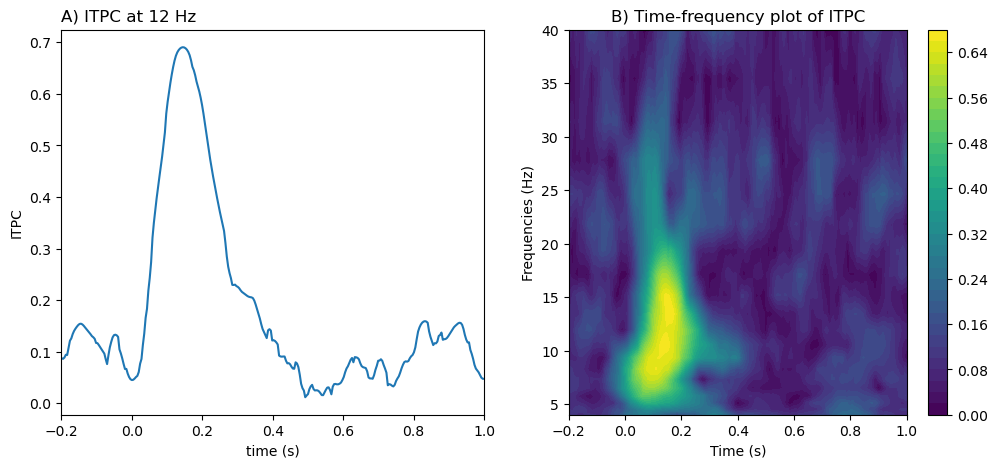

In [7]:
plt.figure(figsize=(12,5))

# get FFT of data
chan2plot= chan_labels.index('Pz')
centerfreq = 12  # in hz
eegfft = np.fft.fft(data[:,chan2plot,:].flatten(), n=n_conv_pow2)

# % ITPC at one frequency band (?)
wavelet = np.exp(2 * 1j * np.pi * centerfreq * time) * np.exp(-time ** 2/ (2*((4/(2*np.pi*centerfreq))**2))) /centerfreq

# convolution
eegconv = np.fft.ifft(np.fft.fft(wavelet, n_conv_pow2) * eegfft)
eegconv = eegconv[:n_convolution]
eegconv = np.reshape(eegconv[pnts//2: -1*pnts//2], [pnts, trials], order='f')


plt.subplot(1,2,1)
plt.plot(times, np.abs(np.mean(np.exp(1j*np.angle(eegconv)), 1)))
plt.setp(plt.gca(), 'xlim', [-.2,1],'xlabel', 'time (s)', 'ylabel', 'ITPC')
plt.title('A) ITPC at 12 Hz', loc='left')

# TF plot of itpc

frequencies = np.logspace(np.log10(4), np.log10(40), 20)
s = np.logspace(np.log10(3),np.log10(10),len(frequencies))/(2*np.pi*frequencies)
itpc = np.zeros((len(frequencies),pnts))

for fi in range(len(frequencies)):
    # create wavelet
    wavelet = np.exp(2*1j*np.pi*frequencies[fi]*time) * np.exp(-time**2/(2*s[fi]**2))/frequencies[fi]

    # convolution
    eegconv = np.fft.ifft(np.fft.fft(wavelet, n_conv_pow2) * eegfft)
    eegconv = eegconv[:n_convolution]
    eegconv = np.reshape(eegconv[pnts//2: -1*pnts//2], (pnts, trials), order='f')

    # extract itpc
    itpc[fi,:] = np.abs(np.mean(np.exp(1j*np.angle(eegconv)),1))

plt.subplot(1,2,2)
plt.contourf(times, frequencies, itpc, 40)
plt.setp(plt.gca(), 'xlim', [-.2,1], 'xlabel','Time (s)', 'ylabel','Frequencies (Hz)')
plt.colorbar()
_=plt.title('B) Time-frequency plot of ITPC')

## Figure 19.5

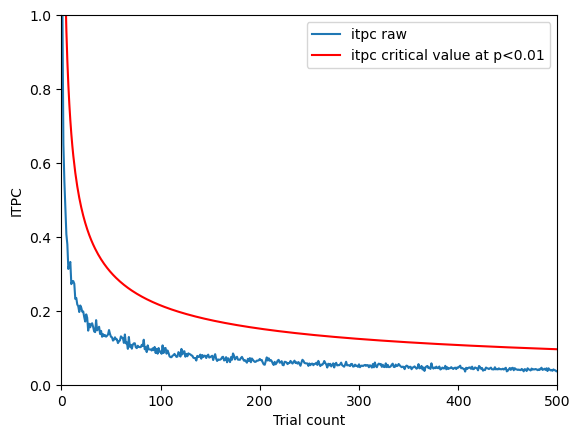

In [8]:
n_trials = 500
itpcByNFake = np.zeros(n_trials)

for n in range(n_trials):
    for i in range(50):
        itpcByNFake[n] = itpcByNFake[n] + np.abs(np.mean(np.exp(1j*(np.random.rand(n+1)*2*np.pi-np.pi))))
itpcByNFake = itpcByNFake/i

itpcByNFakeZ = np.arange(1,n_trials+1)*itpcByNFake**2
itpcByNFakeP = np.exp(np.sqrt(1+4*np.arange(1,n_trials+1)+4*((np.arange(1,n_trials+1)**2) - (np.arange(1,n_trials+1)*itpcByNFake)**2))-(1+2*np.arange(1,n_trials+1)))
itpcByNFakeCrit = np.sqrt(-np.log(.01)/np.arange(1,n_trials+1))

plt.plot(np.arange(1,n_trials+1), itpcByNFake, label='itpc raw')
plt.plot(np.arange(1,n_trials+1), itpcByNFakeCrit, 'r', label='itpc critical value at p<0.01')
plt.setp(plt.gca(), 'xlim', [0,500], 'ylim', [0,1], 'xlabel', 'Trial count', 'ylabel', 'ITPC')
plt.legend()

## Figure 19.6

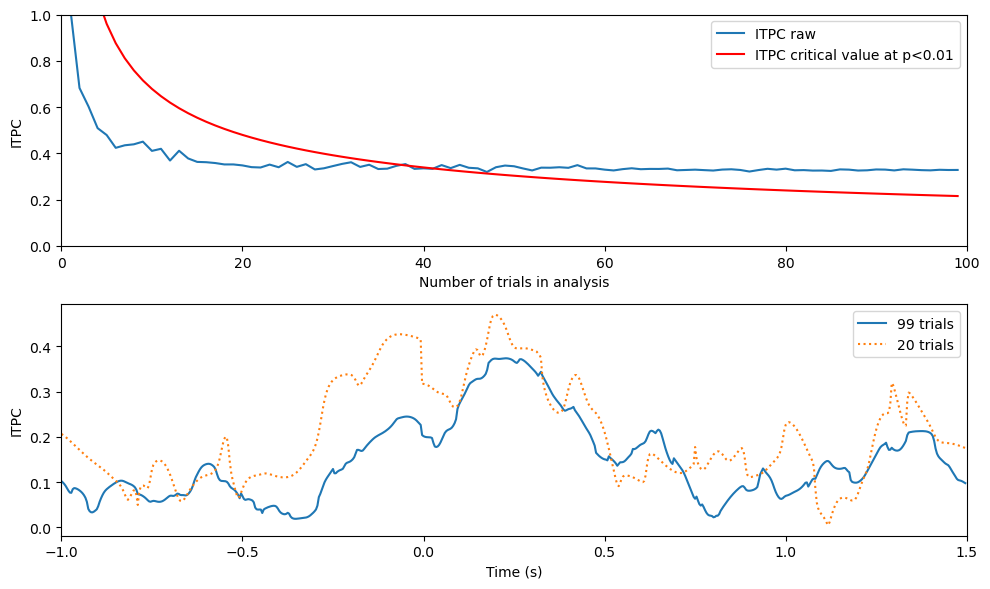

In [9]:
centerfreq = 6
chan2plot= chan_labels.index('FCz')

# create wavelet
time = np.arange(-1*pnts/srate/2, pnts/srate/2, 1/srate)
wavelet = np.exp(2*1j*np.pi*centerfreq*time) * np.exp(-time**2/(2*((4/(2*np.pi*centerfreq))**2)))/centerfreq

# get FFT of data
eegfft = np.fft.fft(data[:,chan2plot,:].flatten(), n=n_conv_pow2)

# convolution
eegconv = np.fft.ifft(np.fft.fft(wavelet, n_conv_pow2) * eegfft)
eegconv = eegconv[:n_convolution]
eegconv = np.reshape(eegconv[pnts//2: -1*pnts//2], (pnts, trials), order='f')

# 
itpcByN = np.zeros(trials)

for n in range(trials):
    # select diff sets of random trials
    for iteri in range(50):
        trials2use = np.random.permutation(np.arange(trials))[:n+1]
        itpcByN[n] = itpcByN[n] + np.mean(np.abs(np.mean(np.exp(1j*np.angle(eegconv[281:371,trials2use])), 1)))

itpcByN = itpcByN/iteri

itpcByNZ = np.arange(1, trials+1)*itpcByN**2
itpcByNP = np.exp(np.sqrt(1+4*np.arange(1,trials+1)+4*((np.arange(1,trials+1)**2) - (np.arange(1,trials+1)*itpcByN)**2))-(1+2*np.arange(1,trials+1)))
itpcCrit = np.sqrt(-np.log(.01)/np.arange(1,trials+1)) # .01 is the p-value in this case

plt.figure(figsize=(10,6))

plt.subplot(2, 1, 1)
plt.plot(np.arange(1,trials+1), itpcByN)
plt.plot(np.arange(1,trials+1), itpcCrit, 'r')
plt.setp(plt.gca(), 'xlim', [0, 100], 'ylim', [0, 1], 'xlabel', 'Number of trials in analysis', 'ylabel','ITPC')
plt.legend(['ITPC raw', 'ITPC critical value at p<0.01'])


plt.subplot(2, 1, 2)
# (Note that this figure will look different than that in the book
# because trials are randomly selected.)
random_trials = np.random.permutation(np.arange(trials))[:20]
plt.plot(times, np.abs(np.mean(np.exp(1j * np.angle(eegconv)), 1)))
plt.plot(times, np.abs(np.mean(np.exp(1j*np.angle(eegconv[:, random_trials])),1)), ":")
plt.setp(plt.gca(), 'xlim', [-1, 1.5], 'xlabel', 'Time (s)', 'ylabel', 'ITPC')
plt.legend(['99 trials', '20 trials'])

plt.tight_layout()

## Figure 34.8

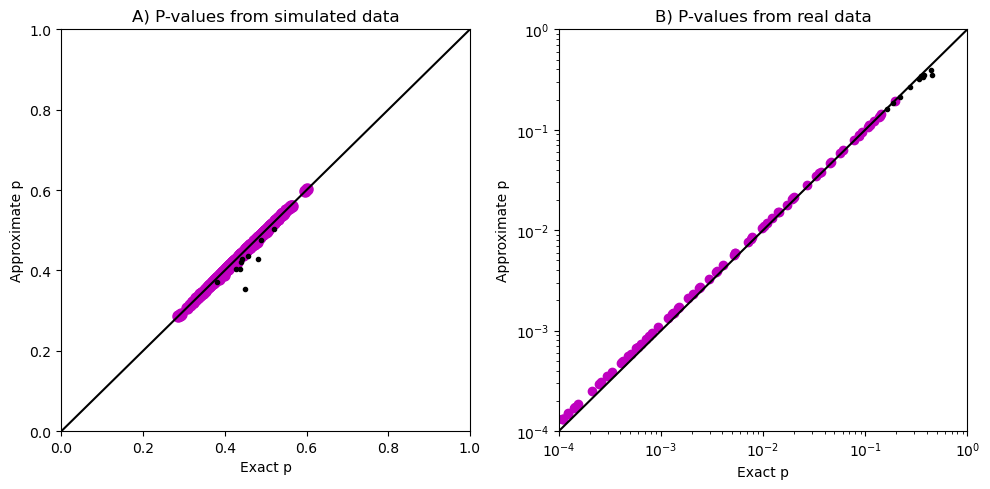

In [10]:
# This cell concerns statistical evaluation of ITPC values. It will be
# discussed in depth in chapter 34, but the code is presented here because
# it relies on calculations from the previous two figures. 

# p-values under assumption of von Mises distribution
approx_pval_fake = np.exp(-itpcByNFakeZ)
approx_pval_real = np.exp(-itpcByNZ)

ncutoff = 10

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(itpcByNFakeP[ncutoff:], approx_pval_fake[ncutoff:],'mo', markersize=8)
plt.plot(itpcByNFakeP[:ncutoff:], approx_pval_fake[:ncutoff], 'k.')
plt.plot([0,1], [0,1], 'k')
plt.setp(plt.gca(),'xlim', [0, 1], 'ylim', [0, 1],'xlabel', 'Exact p', 'ylabel', 'Approximate p')
plt.title('A) P-values from simulated data')

plt.subplot(1,2,2)
plt.plot(itpcByNP[ncutoff:], approx_pval_real[ncutoff:],'mo')
plt.plot(itpcByNP[:ncutoff:], approx_pval_real[:ncutoff], 'k.')
plt.plot([.00001,1], [.00001,1], 'k')
plt.setp(plt.gca(), 'xscale', 'log', 'yscale', 'log', 'xlim', [.0001, 1], 'ylim', [.0001, 1], 'xlabel', 'Exact p', 'ylabel', 'Approximate p')
plt.title('B) P-values from real data')

plt.tight_layout()

## Figure 19.7

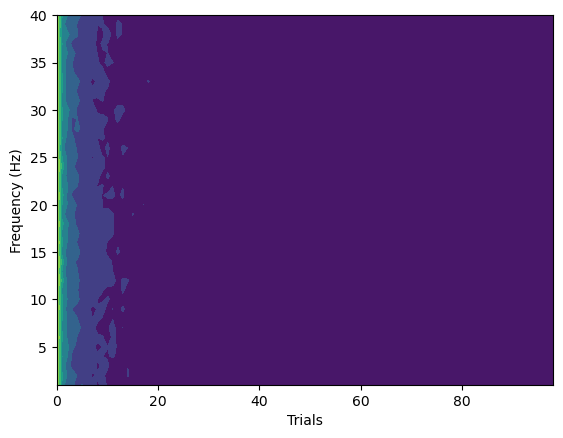

In [11]:
# (This figure takes a while to generate. You could also reduce the number
# of iterations to speed it up.)

# Data for this cell are from figure 19.6. If you want to plot 
# results from a different channel, change the electrode in 19.6.

# center frequencies
frequencies = np.arange(1,41)

niterations = 50

# initialize
itpcByNandF = np.zeros((len(frequencies), trials))

for fi, ff in enumerate(frequencies):
    # create wavelet
    wavelet = np.exp(2*1j*np.pi*centerfreq*time) * np.exp(-time**2/(2*((4/(2*np.pi*centerfreq))**2)))/centerfreq

    # convolution
    eegconv = np.fft.ifft(np.fft.fft(wavelet, n_conv_pow2) * eegfft)
    eegconv = eegconv[:n_convolution]
    eegconv = np.reshape(eegconv[pnts//2: -1*pnts//2], (pnts, trials), order='f')
    
    for n in range(trials):
    # select diff sets of random trials
        for i in range(niterations):
            trials2use = np.random.permutation(np.arange(trials))[:n+1]
            itpcByNandF[fi, n] = itpcByNandF[fi, n] + np.mean(np.abs(np.mean(np.exp(1j*np.angle(eegconv[281:371,trials2use])), 1)))
        
itpcByNandF = itpcByNandF/i

plt.contourf(np.arange(trials), frequencies, itpcByNandF)
plt.xlabel('Trials')
_=plt.ylabel('Frequency (Hz)')

## Figure 19.8

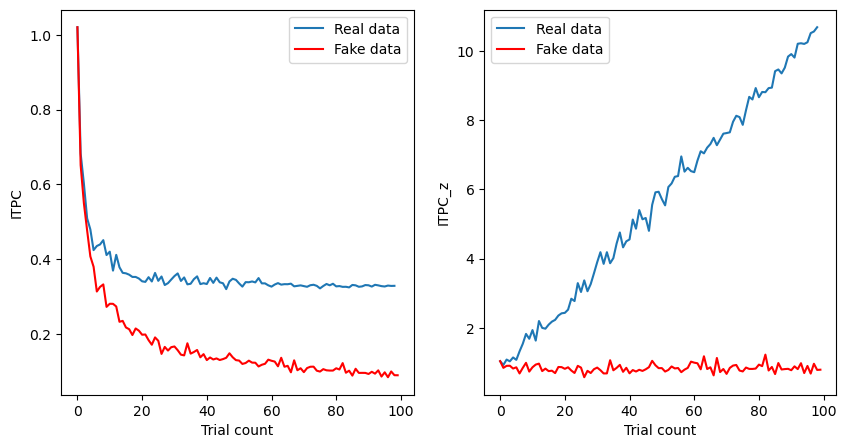

In [12]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(itpcByN)
plt.plot(itpcByNFake[:100], 'r')
plt.setp(plt.gca(), 'xlabel', 'Trial count', 'ylabel', 'ITPC')
plt.legend(['Real data', 'Fake data'])

plt.subplot(1,2,2)
plt.plot(itpcByNZ)
plt.plot(itpcByNFakeZ[:100], 'r')
plt.setp(plt.gca(), 'xlabel', 'Trial count', 'ylabel', 'ITPC_z')
_=plt.legend(['Real data', 'Fake data'])

## Figure 19.9

In [13]:
def dsearchn(X, p):
    disp = X - p
    return np.argmin((disp*disp))

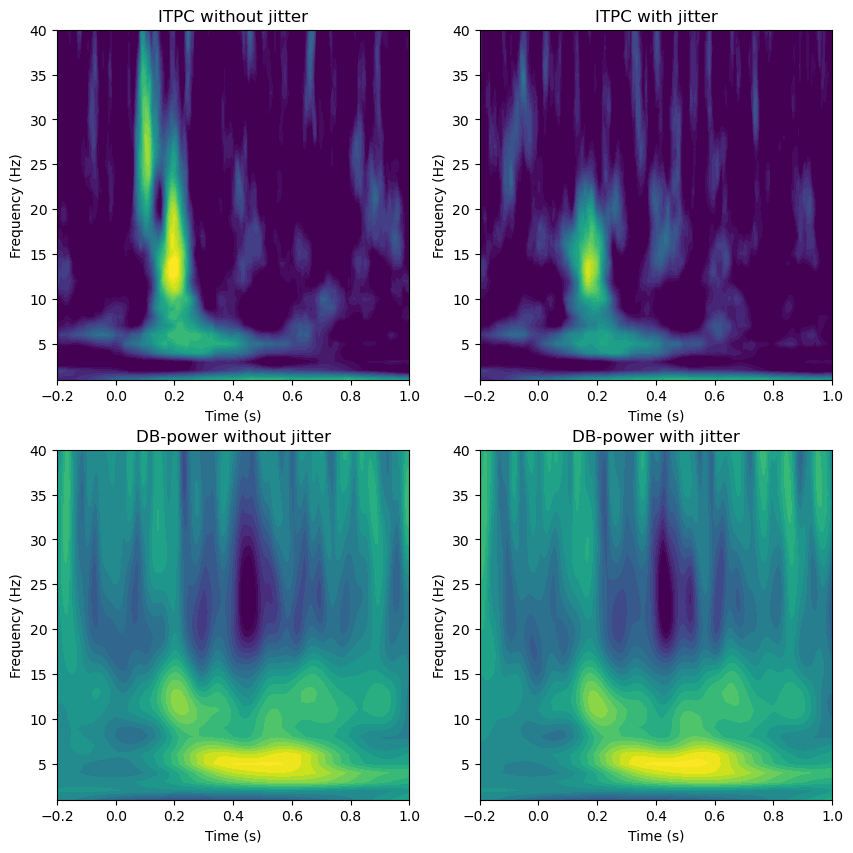

In [14]:
chan2plot = chan_labels.index('FCz')
frequencies = np.arange(1,41,1)

plotlegends=['without jitter','with jitter']


plt.figure(figsize=(10,10))

baselinetime = [-.3, -.1]

baseidx_ = np.array([dsearchn(times,x) for x in baselinetime])
baseidx = np.arange(baseidx_[0],baseidx_[1]+1,1)
baseidx = baseidx.reshape(1,len(baseidx))

for simuli in range(2):
    
    # add time jitter (or not)
    tempdat = data[:, chan2plot,:]
    for ti in range(np.shape(tempdat)[0]):
        timejitter = int(np.ceil(np.random.rand()*10))*(simuli) # (when simuli==0, timejitter==0)
        tempdat[ti, :] = np.roll(tempdat[ti,:], -timejitter)
    
    # get FFT of data
    eegfft = np.fft.fft(tempdat.flatten(),n_conv_pow2)
    
    # initialize
    itpc = np.zeros((len(frequencies),pnts))
    powr = np.zeros((len(frequencies),pnts))
    
    for fi in range(len(frequencies)):
        
        centerfreq = frequencies[fi]
        
        wavelet = np.exp(2*1j*np.pi*centerfreq*time) * np.exp(-time**2/(2*((4/(2*np.pi*centerfreq))**2)))/centerfreq
        
        # convolution
        eegconv = np.fft.ifft(np.fft.fft(wavelet, n_conv_pow2) * eegfft)
        eegconv = eegconv[:n_convolution]
        eegconv = np.reshape(eegconv[pnts//2: -1*pnts//2], (pnts, trials), order='f')
        
        # compute and store itpc and power
        itpc[fi,:] = np.abs(np.mean(np.exp(1j*np.angle(eegconv)), 1))
        powr[fi,:] = np.mean(np.abs(eegconv)**2, 1)
        powr[fi,:] = 10*np.log10(powr[fi,:] / np.mean(powr[fi,baseidx], 1))
    
    plt.subplot(2,2,simuli+1)
    plt.contourf(times,frequencies,itpc,40, vmin=.1, vmax=.5)
    plt.setp(plt.gca(),'xlim',[-.2, 1],'ylim', [1, 40],'xlabel', 'Time (s)', 'ylabel', 'Frequency (Hz)')
    plt.title(f'ITPC {plotlegends[simuli]}')
    
    plt.subplot(2,2,simuli+3)
    plt.contourf(times,frequencies,powr,40,vmin=-3, vmax=3)
    plt.setp(plt.gca(),'xlim',[-.2, 1] ,'ylim', [1, 40],'xlabel', 'Time (s)', 'ylabel', 'Frequency (Hz)')
    plt.title(f'DB-power {plotlegends[simuli]}')

## Figure 19.10

In [15]:
def bandpass(x, samplerate, fp, fs, gpass, gstop):
    fn = samplerate / 2
    wp = fp / fn
    ws = fs / fn
    N, Wn = sig.buttord(wp, ws, gpass, gstop)
    b, a = sig.butter(N, Wn, "band")
    y = sig.filtfilt(b, a, x)
    return y

In [16]:
# initialize
data4test  = np.zeros((2,len(time),trials))
data4test_filt  = np.zeros((2,len(time),trials))
sensor2use = chan_labels.index('P7')

# amplitude modulation (modulate power by 1 Hz sine wave)
#time = np.arange(-1*pnts/srate/2, pnts/srate/2, 1/srate)
amp_mod = (np.sin(2*np.pi*1.*time)+2)-1;

for triali in range(trials):
    # each trial is a random channel and trial
    trialdata = data[triali,sensor2use,:]
    
    # Uncomment the next line of code for band-pass filtered data.
    # This uses the eegfilt function, which is part of the eeglab toolbox. -> original filter func.
    # trialdata = eegfilt(double(trialdata),srate,10,20)
    fp = np.array([10, 20])
    fs = np.array([5, 30])
    trialdata_filt = bandpass(trialdata, srate, fp,fs,3,40)
    
    data4test[0,:,triali] = trialdata*amp_mod
    data4test[1,:,triali] = trialdata
    data4test_filt[0,:,triali] = trialdata_filt*amp_mod
    data4test_filt[1,:,triali] = trialdata_filt

# compute ITPC
itpc_mod   = np.abs(np.mean(np.exp(1j*np.angle(sig.hilbert(data4test[0,:,:], axis=0))),1))
itpc_nomod = np.abs(np.mean(np.exp(1j*np.angle(sig.hilbert(data4test[1,:,:], axis=0))),1))
itpc_mod_filt   = np.abs(np.mean(np.exp(1j*np.angle(sig.hilbert(data4test_filt[0,:,:], axis=0))),1))
itpc_nomod_filt = np.abs(np.mean(np.exp(1j*np.angle(sig.hilbert(data4test_filt[1,:,:], axis=0))),1))

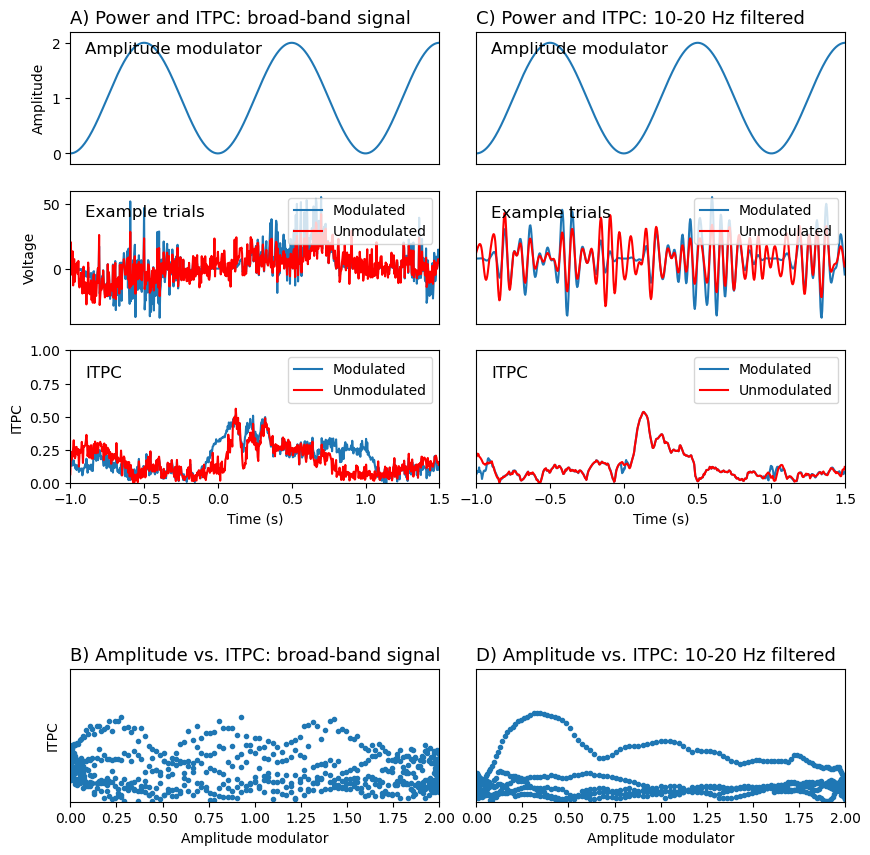

In [17]:
# plot!
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.2, wspace=0.1)
plt.subplot(521)
plt.plot(times,amp_mod)
plt.setp(plt.gca(),'ylim',[-.2, 2.2],'xlim', [-1,1.5], 'xticks', [], 'ylabel', 'Amplitude')
plt.text(-0.9,1.8,'Amplitude modulator', fontsize=12)
plt.title('A) Power and ITPC: broad-band signal', loc='left', fontsize=13)

plt.subplot(523)
plt.plot(times,data4test[0,:,10])
plt.plot(times,data4test[1,:,10],'r')
plt.text(-0.9,40,'Example trials', fontsize=12)
plt.legend(['Modulated','Unmodulated'], loc='upper right')
plt.setp(plt.gca(), 'xlim',[-1,1.5], 'xticks', [], 'ylabel', 'Voltage')

plt.subplot(525)
plt.plot(times,itpc_mod)
plt.plot(times,itpc_nomod,'r')
plt.legend(['Modulated','Unmodulated'])
plt.setp(plt.gca(),'xlim', [-1,1.5], 'ylim',[0, 1], 'xlabel', 'Time (s)', 'ylabel', 'ITPC')
plt.text(-0.9,0.8,'ITPC', fontsize=12)

plt.subplot(529)
plt.plot(amp_mod,itpc_mod,'.')
plt.setp(plt.gca(), 'xlim', [0,2], 'xlabel', 'Amplitude modulator', 'ylabel', 'ITPC', 'yticks', [], 'ylim', [0,0.8])
plt.title('B) Amplitude vs. ITPC: broad-band signal', loc='left', fontsize=13)

plt.subplot(522)
plt.plot(times,amp_mod)
plt.setp(plt.gca(),'ylim',[-.2, 2.2],'xlim', [-1,1.5], 'xticks', [], 'yticks', [])
plt.text(-0.9,1.8,'Amplitude modulator', fontsize=12)
plt.title('C) Power and ITPC: 10-20 Hz filtered', loc='left', fontsize=13)

plt.subplot(524)
plt.plot(times,data4test_filt[0,:,10])
plt.plot(times,data4test_filt[1,:,10],'r')
plt.text(-0.9,4,'Example trials', fontsize=12)
plt.legend(['Modulated','Unmodulated'], loc='upper right')
plt.setp(plt.gca(), 'xlim', [-1,1.5], 'xticks', [], 'yticks', [])

plt.subplot(526)
plt.plot(times,itpc_mod_filt)
plt.plot(times,itpc_nomod_filt,'r')
plt.legend(['Modulated','Unmodulated'])
plt.setp(plt.gca(),'xlim', [-1,1.5], 'ylim',[0, 1], 'yticks', [],'xlabel', 'Time (s)')
plt.text(-0.9,0.8,'ITPC', fontsize=12)

plt.subplot(5,2,10)
plt.plot(amp_mod,itpc_mod_filt,'.')
plt.setp(plt.gca(), 'xlim', [0,2], 'xlabel', 'Amplitude modulator', 'yticks', [], 'ylim', [0,0.8])
_=plt.title('D) Amplitude vs. ITPC: 10-20 Hz filtered', loc='left', fontsize=13)

## Figure 19.11

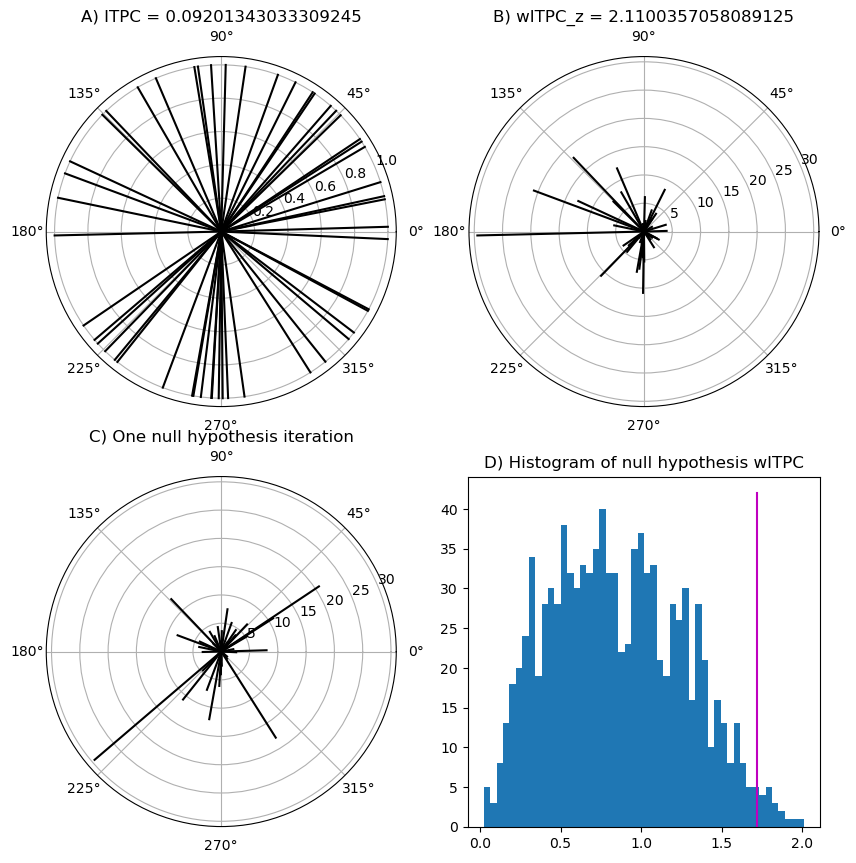

In [18]:
# (This figure is populated with randomly generated data, 
#  and so will look different from the book figure.)


randvects = np.random.rand(50) * 2 * np.pi - np.pi
vectormod = (randvects + np.random.randn(50))**2
vectormod2 = vectormod - np.min(vectormod) + 1  # make sure no negative values

plt.figure(figsize=(10,10))

# ITPC
plt.subplot(221, polar=True)
plt.polar(np.array([np.zeros_like(randvects), randvects]), np.array([np.zeros_like(randvects), np.ones_like(randvects)]), 'k')
plt.title(f'A) ITPC = {np.abs(np.mean(np.exp(1j * randvects)))}')

# wITPC
plt.subplot(222, polar=True)
plt.polar(np.array([np.zeros_like(randvects), randvects]), np.array([np.zeros_like(randvects), vectormod]), 'k')
witpc = np.abs(np.mean(vectormod * np.exp(1j * randvects)))

perm_witpc = np.array([np.abs(np.mean(np.random.permutation(vectormod) * np.exp(1j * randvects))) for _ in range(1000)])
witpc_z = (witpc - np.mean(perm_witpc)) / np.std(perm_witpc)
plt.title(f'B) wITPC_z = {witpc_z}')

# example of one permutation
plt.subplot(223, polar=True)
plt.polar(np.array([np.zeros_like(randvects), randvects]), np.array([np.zeros_like(randvects), np.random.permutation(vectormod)]), 'k')
plt.title('C) One null hypothesis iteration')

# histogram of null-hypothesis WITPC
plt.subplot(224)
plt.hist(perm_witpc, bins=50)
plt.plot([witpc, witpc], plt.gca().get_ylim(), 'm')
plt.title('D) Histogram of null hypothesis wITPC')
plt.show()

## Figure 19.12

In [19]:
# todo

In [20]:
# 応答時間（RT）の計算
rts = np.zeros(EEG.trials)
for ei in range(EEG.trials):
    time0event = np.where(np.array(EEG.epoch[ei].eventlatency) == 0)[0]
    try:
        rts[ei] = EEG.epoch[ei].eventlatency[time0event + 1]
    except IndexError:
        rts[ei] = np.nan

# 畳み込みパラメータの定義
time = np.linspace(-EEG.pnts / EEG.srate / 2, EEG.pnts / EEG.srate / 2 - 1 / EEG.srate, EEG.pnts)
n_wavelet = EEG.pnts
n_data = EEG.pnts * EEG.trials
n_convolution = n_wavelet + n_data - 1
n_conv_pow2 = 2**np.ceil(np.log2(n_convolution))

# データとウェーブレットのFFT
chanidx = np.where(np.array(EEG.chanlocs.labels) == channel2use)[0][0]
eegfft = np.fft.fft(np.reshape(EEG.data[chanidx, :, :], (1, n_data)), n_conv_pow2)
wavefft = np.fft.fft(np.exp(2 * 1j * np.pi * centerfreq * time) * np.exp(-time**2 / (2 * (4 / (2 * np.pi * centerfreq))**2)), n_conv_pow2)

# 畳み込みと位相角の計算
eegconv = np.fft.ifft(wavefft * eegfft)
eegconv = eegconv[0, :n_convolution]
eegconv = np.reshape(eegconv[int((EEG.pnts - 1) / 2):-int((EEG.pnts - 1) / 2)], (EEG.pnts, EEG.trials))
phase_angles = np.angle(eegconv)

# ITPCとwITPCの計算
itpc = np.zeros(len(times2save))
witpc = np.zeros(len(times2save))
witpc_z = np.zeros(len(times2save))

for ti, t in enumerate(times2save):
    timeidx = np.argmin(np.abs(EEG.times - t))
    itpc[ti] = np.abs(np.mean(np.exp(1j * phase_angles[timeidx, :])))
    witpc[ti] = np.abs(np.mean(rts * np.exp(1j * phase_angles[timeidx, :])))
    # 順列検定
    perm_witpc = np.array([np.abs(np.mean(np.random.permutation(rts) * np.exp(1j * phase_angles[timeidx, :]))) for _ in range(1000)])
    witpc_z[ti] = (witpc[ti] - np.mean(perm_witpc)) / np.std(perm_witpc)

# プロット
plt.figure()

# ITPCとwITPCのプロット
plt.subplot(311)
plt.plot(EEG.times, np.abs(np.mean(np.exp(1j * phase_angles), axis=1)))
plt.plot(times2save, witpc)
plt.title(f'ITPC and wITPC at {channel2use}')
plt.legend(['ITPC', 'wITPC'])

# wITPCのZスコアのプロット
plt.subplot(312)
plt.plot(times2save, witpc_z)
plt.axhline(0, color='k')
plt.xlabel('Time (ms)')
plt.ylabel('wITPCz')
plt.title(f'wITPCz at {channel2use}')

# ITPCとwITPCの散布図
plt.subplot(325)
plt.plot(itpc, witpc, '.')
plt.xlabel('ITPC')
plt.ylabel('wITPC')
plt.axis('square')

# ITPCとwITPCzの散布図
plt.subplot(326)
plt.plot(itpc, witpc_z, '.')
plt.xlabel('ITPC')
plt.ylabel('wITPCz')
plt.axis('square')

plt.show()

NameError: name 'EEG' is not defined